<a href="https://colab.research.google.com/github/satwikrakhelkar/assignment2-nlm/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Imports and Setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import random
import os

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


2. Data Preprocessing

In [ ]:
with open("Pride_and_Prejudice-Jane_Austen.txt", "r", encoding="utf-8") as f:
    text = f.read().lower()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)

3. Dataset and Dataloader

In [ ]:
class CharDataset(Dataset):
    def __init__(self, data, block_size):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        chunk = self.data[idx:idx+self.block_size+1]
        return chunk[:-1], chunk[1:]

block_size = 128
batch_size = 64

dataset = CharDataset(data, block_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

4. Model Definition

In [ ]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embed(x)
        out, hidden = self.lstm(x, hidden)
        logits = self.fc(out)
        return logits, hidden

5. Training Loop


In [ ]:
def train_model(model, dataloader, epochs, lr):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []

    for epoch in range(epochs):
        total_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits, _ = model(x)
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

    return train_losses

6. Evaluation and Perplexity


In [ ]:
def compute_perplexity(model, dataloader):
    model.eval()
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    perplexity = np.exp(avg_loss)
    return perplexity

Plotting Function


In [ ]:
def plot_losses(losses, label):
    plt.plot(losses, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

 Underfit Experiment


Epoch 1: Loss = 1.4459
Epoch 2: Loss = 1.3045
Epoch 3: Loss = 1.2866
Epoch 4: Loss = 1.2784
Epoch 5: Loss = 1.2730


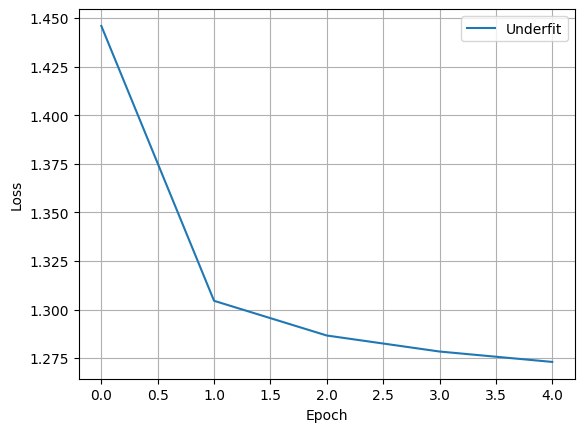

Underfit Perplexity: 3.556038657717831


In [ ]:
embed_dim = 32
hidden_dim = 64
epochs = 5

model_underfit = CharLSTM(vocab_size, embed_dim, hidden_dim)
losses_underfit = train_model(model_underfit, dataloader, epochs, lr=0.003)
plot_losses(losses_underfit, label="Underfit")
perplexity_underfit = compute_perplexity(model_underfit, dataloader)
print("Underfit Perplexity:", perplexity_underfit)

Overfit Experiment


Epoch 1: Loss = 1.0286
Epoch 2: Loss = 0.0898
Epoch 3: Loss = 0.0750
Epoch 4: Loss = 0.0703
Epoch 5: Loss = 0.0679
Epoch 6: Loss = 0.0664
Epoch 7: Loss = 0.0652
Epoch 8: Loss = 0.0644
Epoch 9: Loss = 0.0635
Epoch 10: Loss = 0.0628
Epoch 11: Loss = 0.0622
Epoch 12: Loss = 0.0620
Epoch 13: Loss = 0.0615
Epoch 14: Loss = 0.0612
Epoch 15: Loss = 0.0610
Epoch 16: Loss = 0.0608
Epoch 17: Loss = 0.0602
Epoch 18: Loss = 0.0601
Epoch 19: Loss = 0.0598
Epoch 20: Loss = 0.0599
Epoch 21: Loss = 0.0594
Epoch 22: Loss = 0.0593
Epoch 23: Loss = 0.0591
Epoch 24: Loss = 0.0590
Epoch 25: Loss = 0.0589
Epoch 26: Loss = 0.0589
Epoch 27: Loss = 0.0589
Epoch 28: Loss = 0.0586
Epoch 29: Loss = 0.0584
Epoch 30: Loss = 0.0584


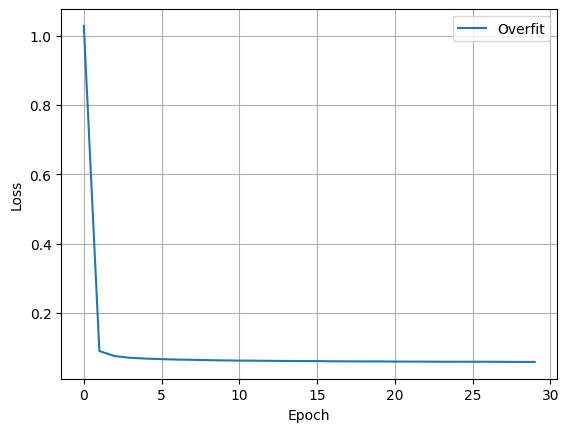

Overfit Perplexity: 1.0556832521047663


In [ ]:
embed_dim = 256
hidden_dim = 512
epochs = 30

small_data = data[:10000]
small_dataset = CharDataset(small_data, block_size)
small_loader = DataLoader(small_dataset, batch_size=batch_size, shuffle=True)

model_overfit = CharLSTM(vocab_size, embed_dim, hidden_dim)
losses_overfit = train_model(model_overfit, small_loader, epochs, lr=0.003)
plot_losses(losses_overfit, label="Overfit")
perplexity_overfit = compute_perplexity(model_overfit, small_loader)
print("Overfit Perplexity:", perplexity_overfit)

Best Fit Experiment

Epoch 1: Loss = 1.0580
Epoch 2: Loss = 0.9054
Epoch 3: Loss = 0.8792
Epoch 4: Loss = 0.8692
Epoch 5: Loss = 0.8645
Epoch 6: Loss = 0.8635
Epoch 7: Loss = 0.8631
Epoch 8: Loss = 0.8654
Epoch 9: Loss = 0.8696
Epoch 10: Loss = 0.8739
Epoch 11: Loss = 0.8841
Epoch 12: Loss = 0.8966
Epoch 13: Loss = 0.9119
Epoch 14: Loss = 0.9295
Epoch 15: Loss = 1.4404


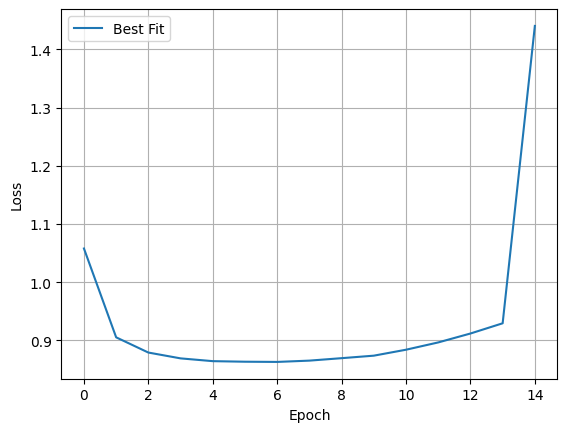

Best Fit Perplexity: 3.3522895458138446


In [ ]:
embed_dim = 128
hidden_dim = 256
epochs = 15

model_bestfit = CharLSTM(vocab_size, embed_dim, hidden_dim)
losses_bestfit = train_model(model_bestfit, dataloader, epochs, lr=0.003)
plot_losses(losses_bestfit, label="Best Fit")
perplexity_bestfit = compute_perplexity(model_bestfit, dataloader)
print("Best Fit Perplexity:", perplexity_bestfit)